<a href="https://colab.research.google.com/github/Raj-Vaghela/Patient-Readmission-Prediction-Part-1-Google-Colab/blob/main/BDPA_CW_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore, skew, normaltest

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/Raj Vaghela/diabetic_data.csv', na_values='?' , low_memory=False)

In [5]:
print(df.describe())
print('\nshape of original data:',df.shape)

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

In [6]:
df.drop(columns=['encounter_id'], inplace = True)

In [7]:
missingValues = df.isnull().sum()
missingValues = missingValues[missingValues>0]
missingPercentage = (missingValues/len(df))*100

missingInfo = pd.DataFrame({'Missing Values': missingValues, 'Missing Percentage': missingPercentage})
print(missingInfo)
print('\nShape after dropping encounter_id:',df.shape)

                   Missing Values  Missing Percentage
race                         2273            2.233555
weight                      98569           96.858479
payer_code                  40256           39.557416
medical_specialty           49949           49.082208
diag_1                         21            0.020636
diag_2                        358            0.351787
diag_3                       1423            1.398306

Shape after dropping encounter_id: (101766, 49)


In [8]:
df['readmitted'] = df['readmitted'].replace({'<30':1, '>30':0, 'NO':0}, )
unique_values = df['readmitted'].unique()
print(unique_values)

[0 1]


In [9]:
columns_to_drop_from_ProblemStatement = ['repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','tolbutamide','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']
col_with_over_90perc_MisVal = missingPercentage[missingPercentage>90].index.tolist()
columns_to_drop = columns_to_drop_from_ProblemStatement + col_with_over_90perc_MisVal
df.drop(columns=columns_to_drop, inplace=True)
print('\nShape of data after dropping cols mentioned in Problem Statement and cols with more than 90% missing values')
print(df.shape)


Shape of data after dropping cols mentioned in Problem Statement and cols with more than 90% missing values
(101766, 31)


In [10]:
df_without_null = df.dropna()
df_without_null.shape

(26755, 31)

In [11]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

for column in df_without_null.select_dtypes(include=['int64', 'float64']).columns:
    if column !='readmitted':
        outliers = count_outliers_iqr(df_without_null[column])
        num_outliers = outliers.sum()
        # x = outliers.any(axis=0)
        df_no_outliers = df_without_null[~outliers]
        print(f"Number of outliers by IQR in '{column}': {num_outliers}")


Number of outliers by IQR in 'patient_nbr': 0
Number of outliers by IQR in 'admission_type_id': 0
Number of outliers by IQR in 'discharge_disposition_id': 1755
Number of outliers by IQR in 'admission_source_id': 822
Number of outliers by IQR in 'time_in_hospital': 517
Number of outliers by IQR in 'num_lab_procedures': 64
Number of outliers by IQR in 'num_procedures': 1533
Number of outliers by IQR in 'num_medications': 768
Number of outliers by IQR in 'number_outpatient': 3860
Number of outliers by IQR in 'number_emergency': 4050
Number of outliers by IQR in 'number_inpatient': 1928
Number of outliers by IQR in 'number_diagnoses': 15


In [12]:
df_no_outliers.shape

(26740, 31)

In [13]:
df_no_outliers['readmitted']
unique_values = df_no_outliers['readmitted'].unique()
print(unique_values)

[0 1]


In [14]:
df_no_outliers.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
glipizide                   object
glyburide                   object
pioglitazone                object
rosiglitazone               object
insulin                     object
change              

In [15]:
for column in df_no_outliers.select_dtypes(include=['int64', 'float64']).columns:
    print(f"Summary statistics for column '{column}':")
    print(df_no_outliers[column].describe())
    print()

Summary statistics for column 'patient_nbr':
count    2.674000e+04
mean     5.731091e+07
std      3.708903e+07
min      7.290000e+02
25%      2.425005e+07
50%      4.401442e+07
75%      9.229607e+07
max      1.893659e+08
Name: patient_nbr, dtype: float64

Summary statistics for column 'admission_type_id':
count    26740.000000
mean         2.019110
std          0.946634
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: admission_type_id, dtype: float64

Summary statistics for column 'discharge_disposition_id':
count    26740.000000
mean         2.958190
std          4.323303
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         28.000000
Name: discharge_disposition_id, dtype: float64

Summary statistics for column 'admission_source_id':
count    26740.000000
mean         4.973149
std          3.522718
min          1.000000
25%          1.000000
50%          7.000000
75%      

In [16]:
col_to_normalize = ['number_inpatient','number_emergency','number_outpatient','num_medications','num_procedures','num_lab_procedures','time_in_hospital','number_diagnoses']

def min_max_scaling(x):
    return (x - x.min()) / (x.max() - x.min())

df_no_outliers[col_to_normalize] = df_no_outliers[col_to_normalize].apply(min_max_scaling)
print(df_no_outliers)

        patient_nbr       race  gender       age  admission_type_id  \
20446      20123568  Caucasian  Female   [70-80)                  1   
20737      20377854  Caucasian  Female   [60-70)                  2   
20824      20408121  Caucasian  Female  [90-100)                  1   
21083      20542797  Caucasian    Male   [70-80)                  1   
23879       7239654  Caucasian  Female   [70-80)                  1   
...             ...        ...     ...       ...                ...   
101735    106595208  Caucasian    Male   [70-80)                  2   
101743     47293812  Caucasian    Male   [80-90)                  1   
101747     33230016  Caucasian  Female   [70-80)                  1   
101749    106392411  Caucasian  Female   [70-80)                  3   
101764     31693671  Caucasian  Female   [80-90)                  2   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
20446                         22                    7          0.461538 

<ipython-input-16-17d9ac992ffc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers[col_to_normalize] = df_no_outliers[col_to_normalize].apply(min_max_scaling)


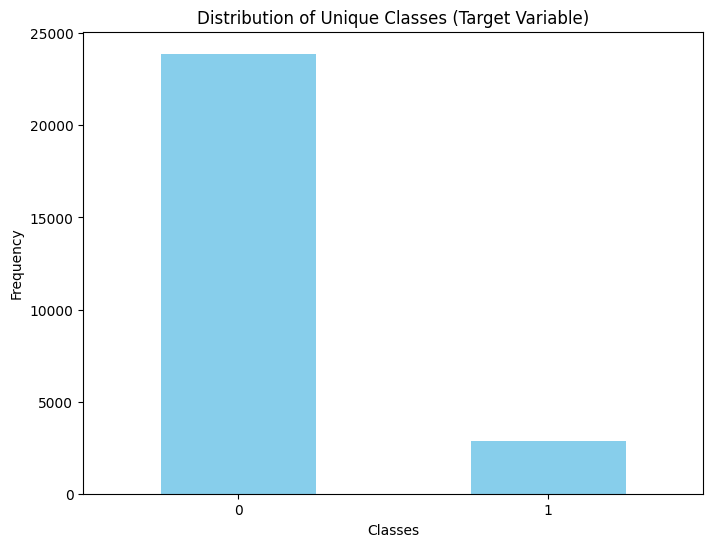

In [17]:
class_counts = df_no_outliers['readmitted'].value_counts()

# Plot the distribution of unique classes
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Unique Classes (Target Variable)')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

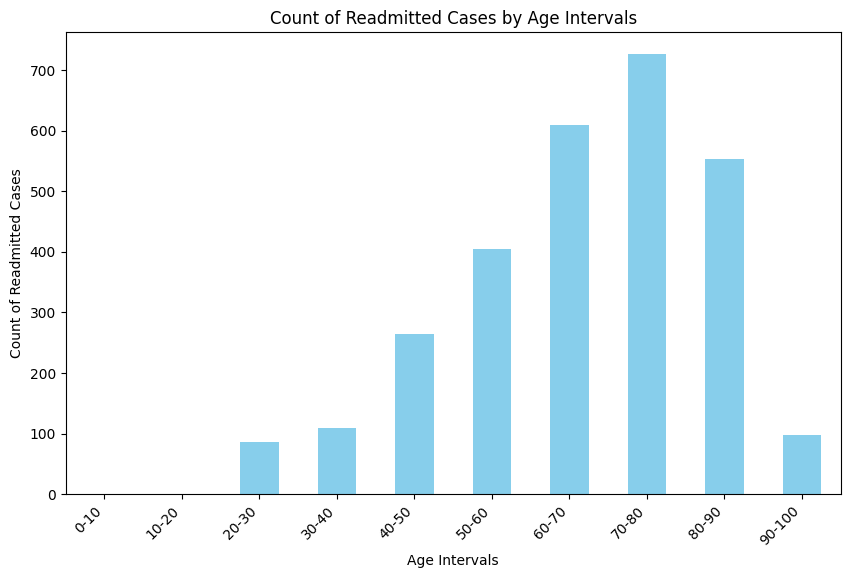

In [18]:
age_intervals = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']

# Group data by age intervals and count readmitted cases
readmitted_counts = df_no_outliers.groupby('age')['readmitted'].sum()

# Convert age intervals to corresponding labels
readmitted_counts.index = age_labels

# Plot the count of readmitted cases against age intervals
plt.figure(figsize=(10, 6))
readmitted_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Age Intervals')
plt.ylabel('Count of Readmitted Cases')
plt.title('Count of Readmitted Cases by Age Intervals')
plt.xticks(rotation=45, ha='right')
plt.show()



<Figure size 1400x400 with 0 Axes>

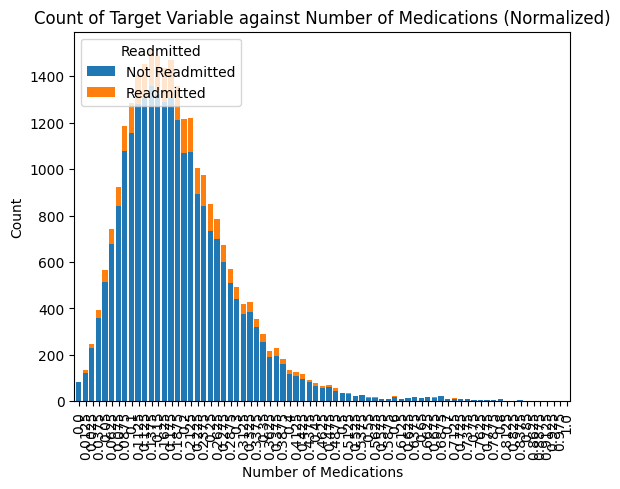

In [22]:
target_counts = df_no_outliers.groupby('num_medications')['readmitted'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(14,4))
bars = target_counts.plot(kind='bar', stacked=True, width=0.8, align='center')  # Set align='center' to align bars to tick labels

# Get the current positions of the bars
positions = np.arange(len(target_counts))

# Manually adjust the positions of the bars
plt.xticks(positions + 0.2 * (len(target_counts.columns) - 1) / 2, target_counts.index)
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.title('Count of Target Variable against Number of Medications (Normalized)')
plt.legend(title='Readmitted', loc='upper left', labels=['Not Readmitted', 'Readmitted'])
plt.xticks(rotation=90)
plt.show()


<Figure size 1400x600 with 0 Axes>

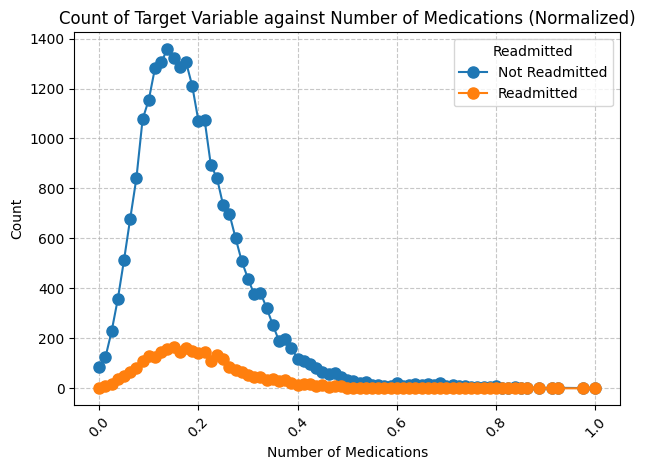

In [20]:
target_counts = df_no_outliers.groupby('num_medications')['readmitted'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
target_counts.plot(kind='line', marker='o', markersize=8)
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.title('Count of Target Variable against Number of Medications (Normalized)')
plt.legend(title='Readmitted', loc='upper right', labels=['Not Readmitted', 'Readmitted'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


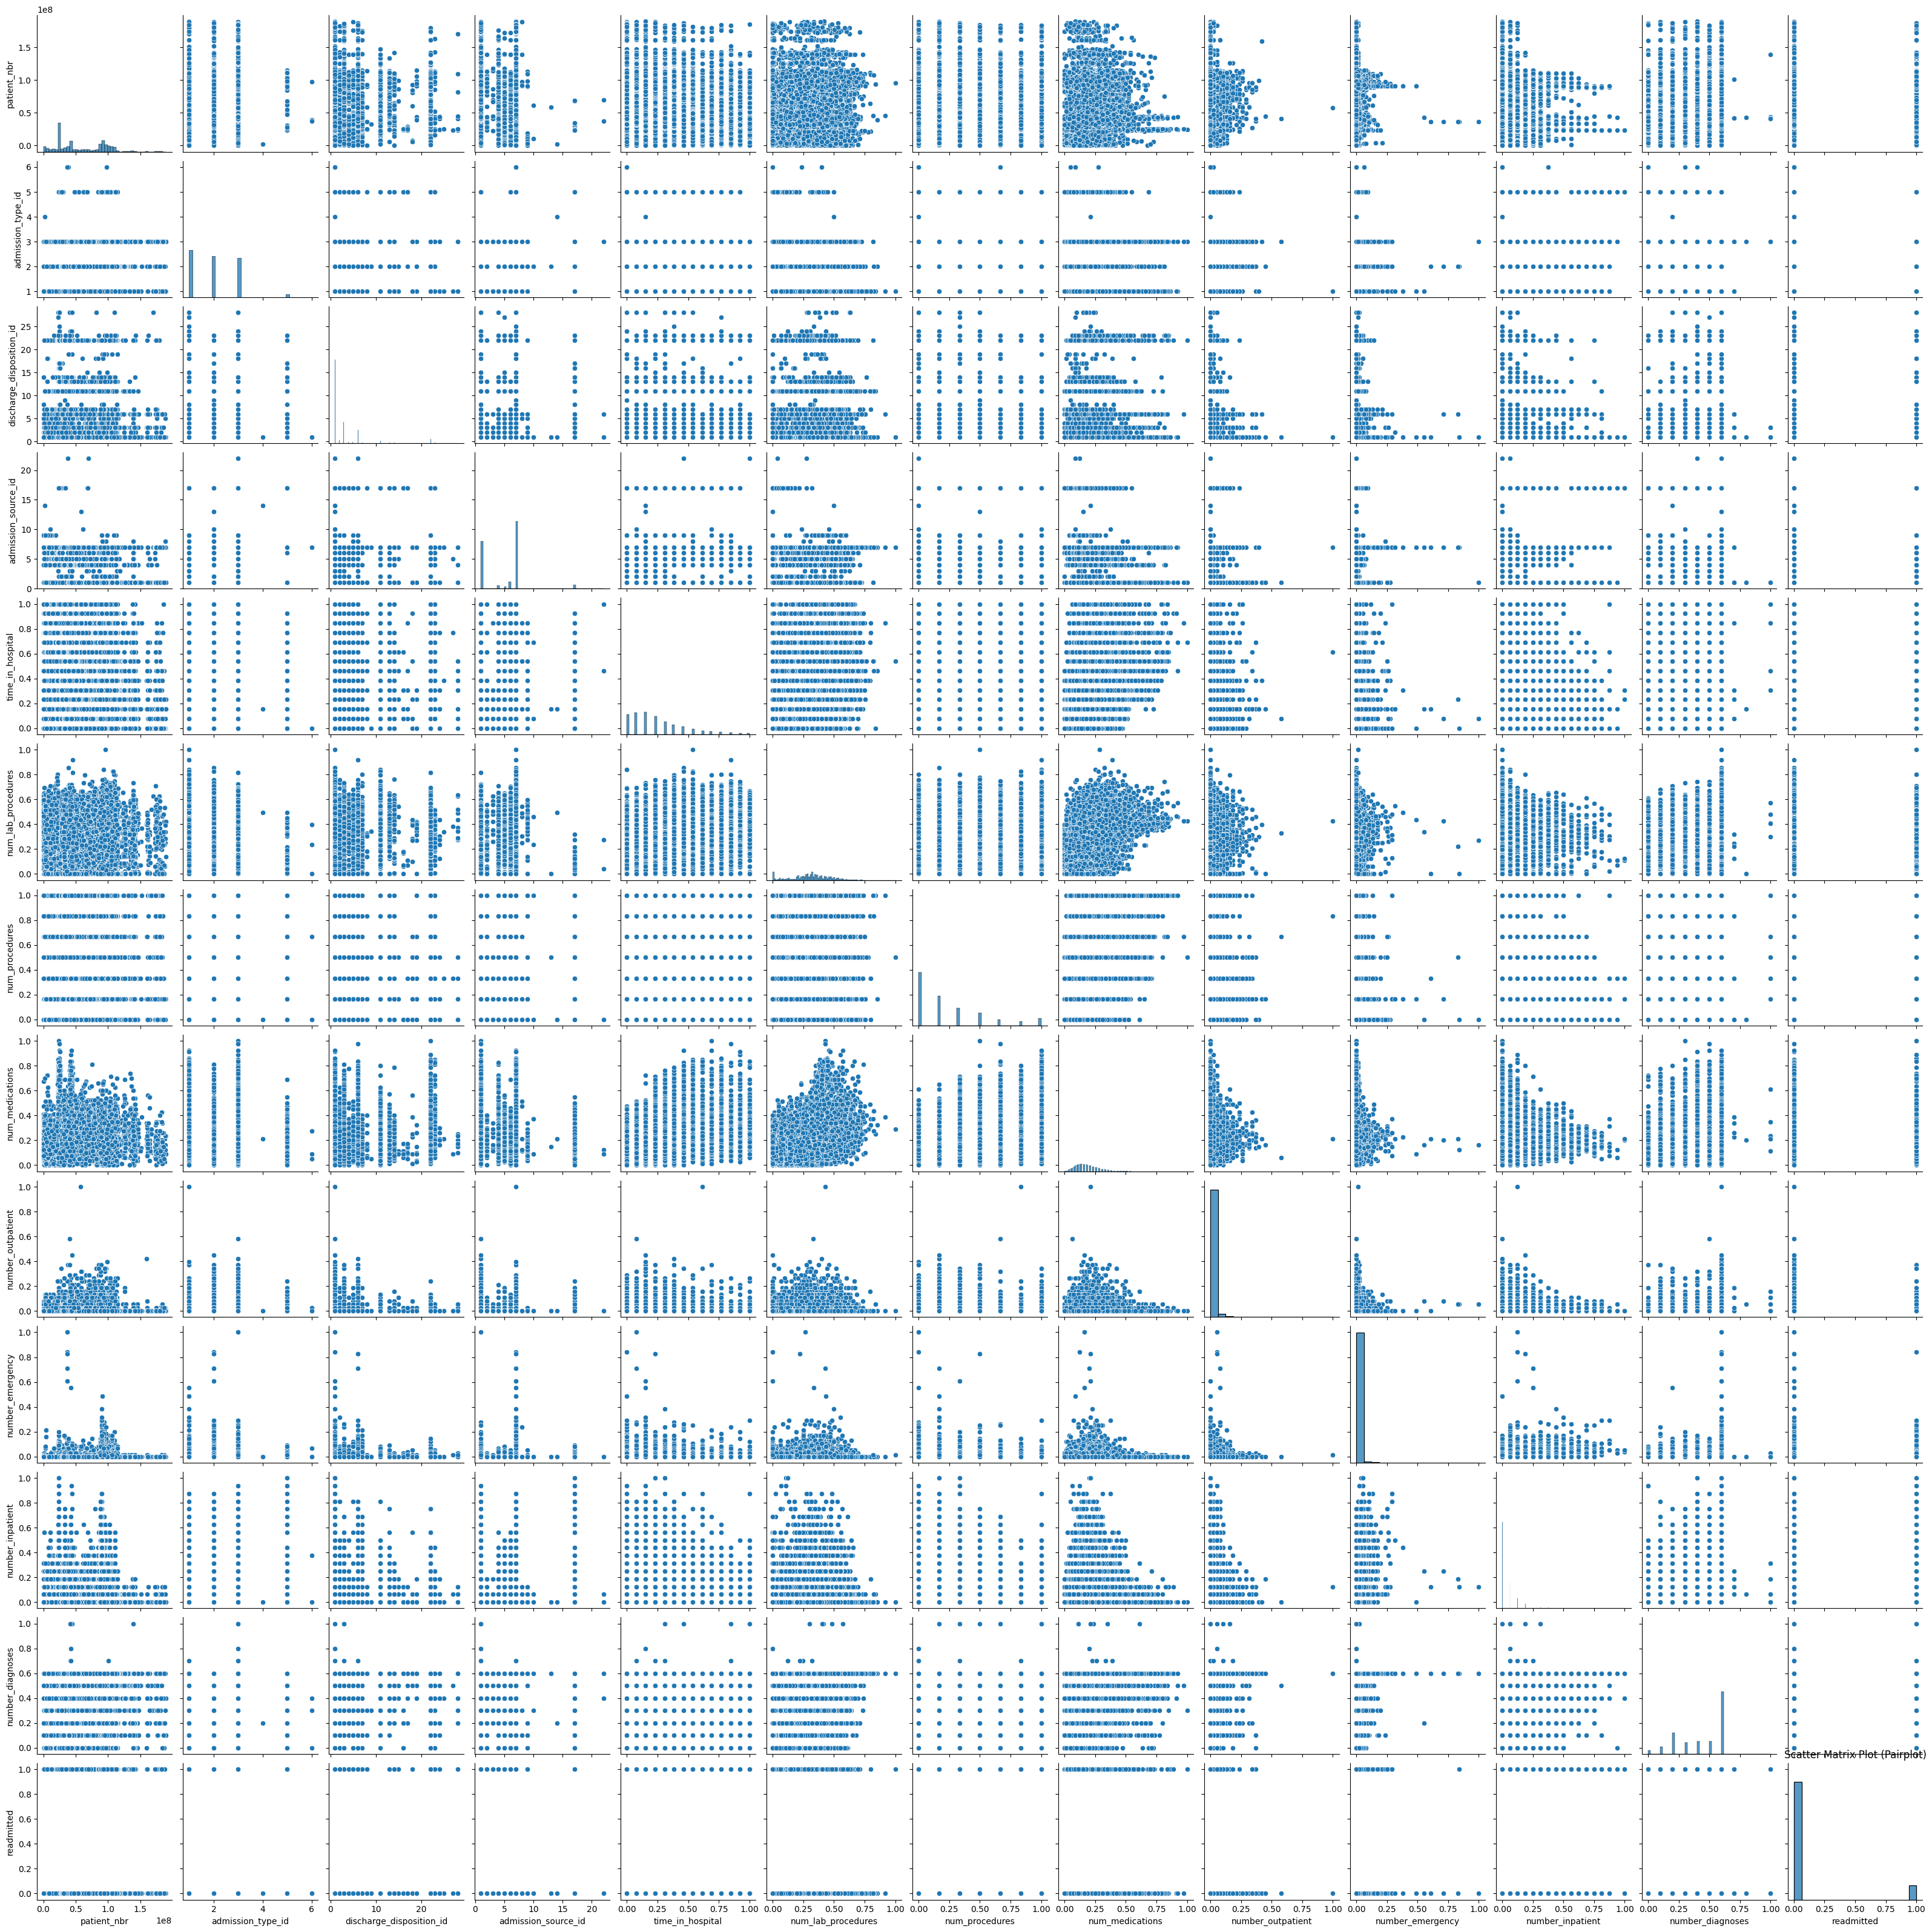

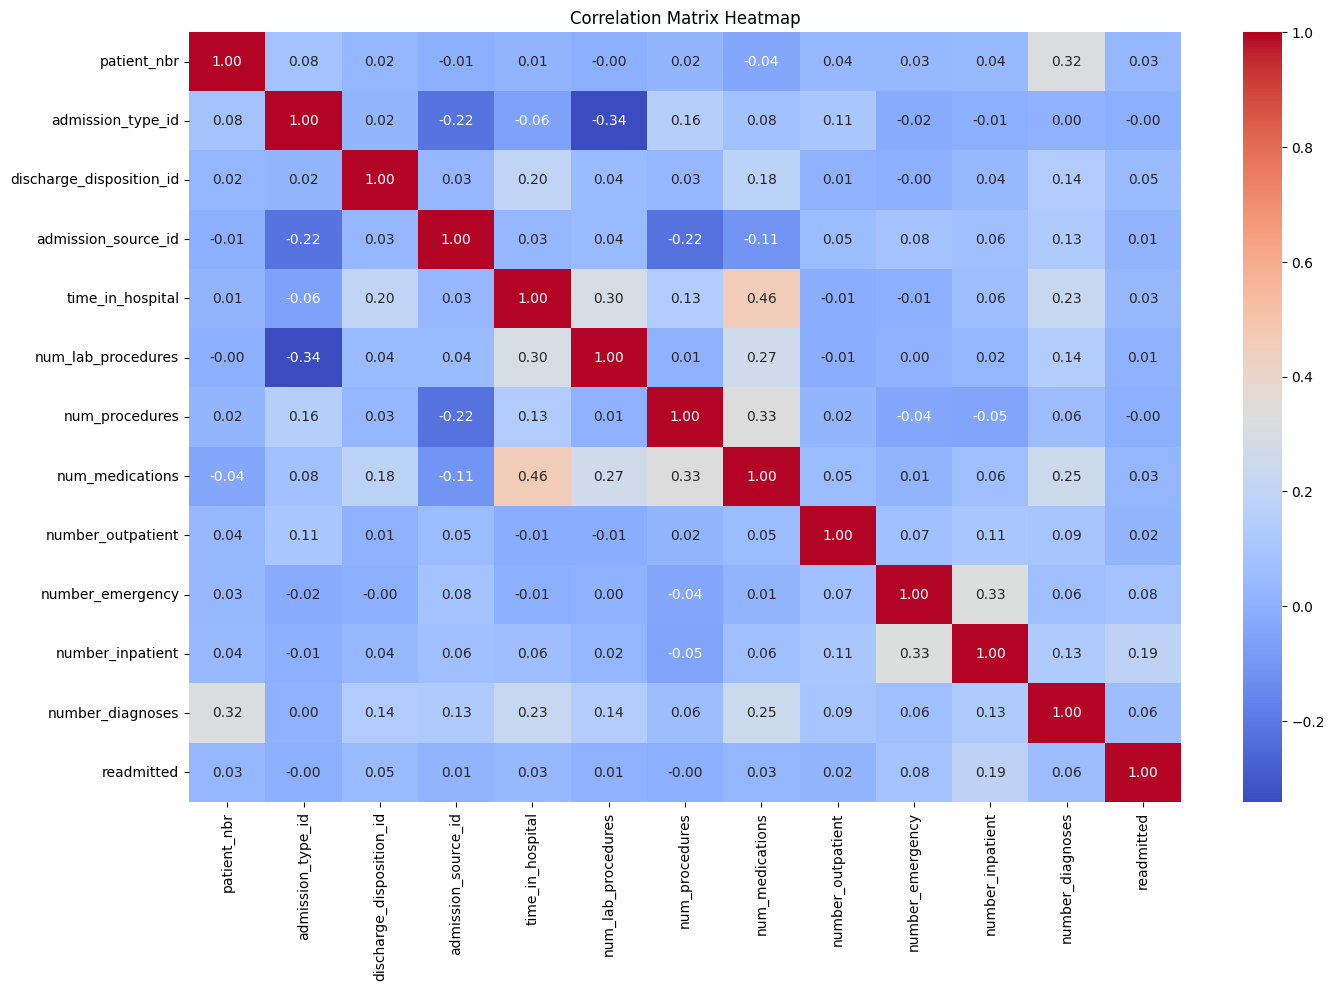

In [23]:
import seaborn as sns
sns.pairplot(df_no_outliers)
plt.title('Scatter Matrix Plot (Pairplot)')
plt.show()

correlation_matrix = df_no_outliers.corr(numeric_only=True)

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()
